In [1]:
from DELCgen import *
import scipy.stats as st
import matplotlib.pyplot as plt 
from constants import *
from scipy.interpolate import interp1d
import naima
import astropy.units as u
import subroutines as sub
import os
import time

This piece of code runs a simple simulation where a CR population is injected and evolved with a variable jet. We need to define the maximum rigidity which is related to the jet power
$$
R_{\mathrm{max}} = 10^{19}~V\left(\frac{Q_j}{10^{44}~\mathrm{erg~s}^{-1}}\right)^{1/2}
    \left(\frac{\eta}{0.1}\right)
    \left(\frac{u}{0.1c}\right).
$$

the "power threshold" is the inverse expression with $Q_j$ as the subject. We use an input power spectral density (PSD) and jet power probability distribution function (PDF) to generate a time series for the jet power for a given set of PSD and PDF parameters. To do this, we use the method described by Emmanolopoulous et al. and implemented in python by Connolly. The PSD is implemented as a bending power-law model of the form 

$$\mathrm{PSD}(\nu,\bar{Q},\nu_c) = A(\bar{Q}) \frac{\nu^{-\alpha_{\mathrm{low}}}}
               {1+(\nu/\nu_c)^{\alpha_{\mathrm{high}}-\alpha_{\mathrm{low}}}}$$
               
               
We set $\alpha_{\mathrm{low}} = 1$ for a pink noise spectrum, $\alpha_{\mathrm{high}} = 10$ so as to suppress high frequency variability, and $\nu_c = 1$Myr, roughly equal to the light travel time, $\tau_c=L/c$, along a $L=300$kpc jet. The acceleration time relates to $\tau_c$ by $\tau_\mathrm{acc}/\tau_c \approx (Rc)/(uL)$, since the highest energy particles reach Larmor radii comparable to $(u/c)R$ (Hillas criterion). The longest CR acceleration time is therefore shorter than the light travel time along the jet for any fast, long and thin jet ($u/c>R/L$). 

In [2]:
def power_threshold(rigidity, v_over_c=0.1, eta=0.1):
    power = (0.1 / eta) * (rigidity / 1e19)**2 * (0.1/v_over_c) * 1e44
    return power 

def max_energy(power, v_over_c=0.1, eta=0.1):
    return 1e19*np.sqrt( (power/1e44) * (v_over_c/0.1))

def get_lc(lognorm_params, PSD_params, tbin, Age):
    # Simulation params
    # let's do everything in units of kyr
    # run for 100 Myr (1e5 kyr) in bins of 0.1 Myr
    #lognorm_params = (1.5,0,np.exp(1.5))
    RedNoiseL,RandomSeed,aliasTbin = 100,12,100
    N = Age / tbin

    lc = Simulate_DE_Lightcurve(BendingPL, PSD_params,st.lognorm,lognorm_params,
                                    RedNoiseL=RedNoiseL,aliasTbin=aliasTbin,randomSeed=RandomSeed,LClength=Age, tbin=tbin)

    return (lc)

Now we've set up the basic functions. Let's initialise our parameters for the variable jet history and initialise the tau_loss dictionary which stores the loss times for the different species (calculated using CRPropa).  

In [3]:
# since we're in Kyr units, set up conversion
MYR = 1e3

# set up light curve. pl_index of 1 means red noise.
pl_index = 1

# bend the power law at 1 Myr (1e-3 kyr^-1) and steeply decay it beyond that with index 10. 
# A,v_bend,a_low,a_high,c = 1, 1e-3, pl_index, 10, 1
PSD_params = (1, 1.0 * MYR, pl_index, 10, 1)
tbin = 0.1 * MYR   # 100 kyr 
Age = 100.0 * MYR
Length = int(Age / tbin)

# time is in kyr, so convert to Myr
times = np.arange ( 0, Length*tbin, tbin) 

energies = np.logspace(6,20.5,num=3000)
lognorm_params = (1.5,0,np.exp(1.5))
    
# paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
lc = get_lc(lognorm_params, PSD_params, tbin, Length)

Set up arrays to loop over. flux_scales contains the normalisations of our jet power $(\bar{Q})$.
This is actually the median of the distribution, or the mean in log space.
betas is the spectral index of the injected spectrum ($\beta$).

In [4]:
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
#flux_scales = np.logspace(43,45,num=10)
betas = [2,2.3,2.7]
flux_scales = np.logspace(42.5,44.5,num=10)
sigmas = np.linspace(0.5,3,num=10)

NameError: name 'xlims' is not defined

<Figure size 432x288 with 0 Axes>

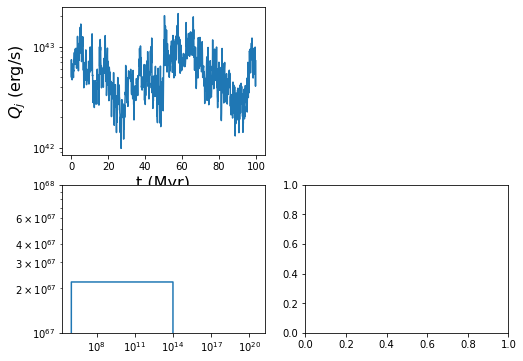

In [5]:
energies = np.logspace(6,20.5,num=3000)

for i_sigma, sigma in enumerate(sigmas):
    
    lognorm_params = (sigma,0,np.exp(sigma))
    # paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
    lc = get_lc(lognorm_params, PSD_params, tbin, Length)
                      
    for i_flux, flux_scale in enumerate(flux_scales):

        # normalise the light curve
        flux = lc.flux * flux_scale 

        # loop over spectral indices
        for i_beta, BETA in enumerate(betas):
        
            # load the arrays calculated
            ncr_time = np.load ("array_saves/ncr_beta{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale), sigma))
            dimensions = np.load("array_saves/dim_{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale), sigma))
            
            
            # elemental "abundances" - really injection fractions 
            # this is roughly solar, but should probably be top heavy since it is easier to inject heavy ions, generally
            frac_elem = np.array([1.0,0.1,1e-4,3.16e-05])

            # normalise! 
            frac_elem /= np.sum(frac_elem)

            # get the time step - IMPROVE 
            delta_t = tbin * 1000.0 * YR

            # charges 
            z_elem = np.array([1,2,7,26])

            lgamma = np.zeros_like(flux)

            movie_counter = 0
            DELTA = 3

            i = len(flux) -1 

            #for i in range(0,len(flux), DELTA):
            # get the maximum rigidity from the power requirement
            Rmax = max_energy(flux[i], v_over_c=0.5)

            # this plots the lightcurve 
            fig, ax2, ax3 = sub.init_lc_plot(lc.time[:i+1] / 1000.0, flux[:i+1])


            for j, frac in enumerate(frac_elem):

                rigidities = energies / z_elem[j]

                sub.plot_spectra_morph(fig, ax2, ax3, rigidities * z_elem[j], ncr_time[j,i,:], dimensions, j)


            #os.system("mkdir spectra/beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale)))
            plt.savefig("spec_beta{:.1f}q{:.1f}.png".format(BETA, np.log10(flux_scale)), dpi=100)
            plt.close("all")
            movie_counter += 1

            print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e}".format(BETA, flux_scale, np.mean(flux)))


Let's loop over the flux scales and the spectral indices. The method is as follows. For each value of $\bar{Q}$ and $\beta$, we evolve a CR distribution for each ionic species numerically using the following equation,

$$
    \frac{dn_i(E)}{dt} = S(E/Z_i, f_i, t) - \frac{n(E)}{\tau_\mathrm{esc} (E/Z_i)} - \frac{n(E)}{\tau_\mathrm{loss} (E, Z_i)}.
$$

The total differential CR spectrum is then just $n(E,t)=\sum_i n_i(E,t)f_i$. We follow, e.g., Eichmann et al. 2018 in using a power-law for the injection term $S({\cal R}_i, f_i, t)$ with a sharp cutoff, given by

$$
    S(E/Z_i, f_i, t) = 
    f_i \eta Q_j(t)~\nu_i
    \left(\frac{{\cal R}}{{\cal R}_0}\right)^{-\beta}~f_{\mathrm{cut}}(R_{\mathrm{max}}).
    % f_\mathrm{cut}
$$

where $\nu_i$ is the normalisation of the distribution and is given by $\nu_i=1.0/[\ln({\cal R}_\mathrm{max}(t)/{\cal R}_0]$ for $\beta=2$ and $\nu_i=(2-\beta)/[({\cal R}_\mathrm{max}/{\cal R}_0)^{(2-\beta)}-1]$ for $\beta > 2$.  We set ${\cal R}_\mathrm{max}$ according to the maximum rigidity condition, ${\cal R}_0=1\mathrm{GV}$. 

In [ ]:
energies = np.logspace(6,20.5,num=3000)
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
betas = [2]
#flux_scales = np.logspace(42.5,44.5,num=10)
flux_scales = flux_scales = np.logspace(42.5,44.5,num=10)
sigmas = np.linspace(0.5,3,num=10)

for i_sigma, SIGMA in enumerate(sigmas):
    
    lognorm_params = (SIGMA,0,np.exp(SIGMA))
    
    # paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
    lc = get_lc(lognorm_params, PSD_params, tbin, Length)
                      
    for i_flux, flux_scale in enumerate(flux_scales):
        # normalise the light curve
        flux = lc.flux * flux_scale 
    
        # loop over spectral indices
        for i_beta, BETA in enumerate(betas):
            
            print (i_beta)

            # initialise figure and movie file name
            fname = "movies/movie_beta{:.1f}q{:.1f}sig{:.1f}".format(BETA, np.log10(flux_scale),  SIGMA)
            p, fig, ax1, ax2, ax3 = sub.init_fig(fname=fname, fmt="mp4", fps=6)

            # load the arrays calculated
            escaping_time = np.load("array_saves/escaping_beta{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale),  SIGMA))
            ncr_time = np.load("array_saves/ncr_beta{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale),  SIGMA))
            #import os
            #print (os.getcwd())
            dimensions = np.load("array_saves/dim_{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale),  SIGMA))
            
            # get the time step - IMPROVE 
            delta_t = tbin * 1000.0 * YR

            # charges 
            z_elem = np.array([1,2,7,26])

            movie_counter = 0
            DELTA = 2

            for i in range(1,len(flux), DELTA):            
                # this clears axes and plots the lightcurve 
                ax1.clear()
                sub.plot_lc(ax1, lc.time[:i+1] / 1000.0, flux[:i+1])
                ax2.clear()
                ax3.clear()
                ax = fig.add_subplot(2,2,2)
                ax.clear()


                for j, frac in enumerate(z_elem):
                    sub.plot_spectra(fig, ax2, ax3, energies, ncr_time[j,i,:], escaping_time[j,i,:]*delta_t, j)

                ax = fig.add_subplot(2,2,2)
                ax.plot(dimensions[1,i,:], dimensions[0,i,:])
                plt.draw()

                # extract the image as an ARGB string
                string = fig.canvas.tostring_argb()

                # write to pipe
                p.stdin.write(string) 


            print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e}".format(BETA, flux_scale, np.mean(flux)))
            # Finish up
            p.communicate()

            print ("{:.2f} seconds".format(time.time() - t1))


 

Now let's make a movie with ffmpeg (pretty hacky this)

In [ ]:
import os
import io
import base64
from IPython.display import HTML

# for i_flux, flux_scale in enumerate(flux_scales):
#     for i_beta, BETA in enumerate(betas):
#         print (flux_scale, BETA)
#         fname = "beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale))
#         #cmd = "ffmpeg -y -i spectra/{}/spectra%3d.png -r 6 movies/movie_{}.mp4".format(fname,fname)
#         cmd = "ffmpeg -y -i spectra/{}/spectra%3d.jpg -r 6 movies/movie_{}.gif".format(fname,fname)
#         os.system(cmd)
#         time.sleep(3)
        
# open the last movie?  
moviename = "movies/movie_{}.mp4".format(fname)
video = io.open(moviename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

from IPython.display import Video

Video(moviename )

In [ ]:
from py_plot_util import smooth
rms = np.std(ncr_time, axis=1) / np.mean(ncr_time, axis=1)
#rms = np.std(ncr_time[0]*energies*energies, axis=0)
print (rms.shape, ncr_time.shape)

from scipy.fftpack import fft

reference_energies = [18,19,np.log10(6e19)]
indices = np.zeros(3)
#for i, r in enumerate(reference_energies):
indices = np.array([np.argmin( np.fabs(np.log10(energies) - r)) for r in reference_energies])

print (indices)
#indices = [-200,-700,-1000]
#plt.plot(np.arange(0,100,0.1), ncr_time[0,:,-200])
#plt.plot(np.arange(0,100,0.1), ncr_time[0,:,-100])
fig1 = plt.figure()
labels = ["EeV", "10 EeV", "60 EeV"]
for ii, i in enumerate(indices):
    plt.plot(np.arange(0,50,0.1), ncr_time[0,:,i]/np.mean(ncr_time[0,:,i]), label = labels[ii])
    
plt.plot(np.arange(0,50,0.1), flux/np.mean(flux), alpha=0.5, label="Jet")
plt.legend()
plt.semilogy()
plt.xlabel("time (Myr)")
plt.ylabel("$n(E)$ or jet power")
plt.savefig("proton_lc.png", dpi=300)

age = 500
Freq = np.arange(1, age+1) / (age*tbin/1000.0)

fig2 = plt.figure()

ff = fft(flux)
psd_lc = np.absolute(ff)**2.0 
psd_lc /= np.max(psd_lc)
plt.plot(Freq, smooth(psd_lc/np.max(psd_lc)), c="k", alpha=0.6)

# (v,A,v_bend,a_low,a_high,c
v_bend = 10 * (1e19 / 6e19) 
psd2 = BendingPL(Freq, 1, v_bend, 1, 10, 1)
plt.plot(Freq, psd2/np.max(psd2), ls="--")

for ii, i in enumerate(indices):
    ff = fft(ncr_time[0,:,i])
    psd = np.absolute(ff)**2.0
    plt.plot(Freq, smooth(psd/np.max(psd)), color="C" + str(ii), label=labels[ii])
    cooling_time = 10 * (1e19 / energies[i]) 
    plt.vlines([1/cooling_time], 1e-6,10, color="C" + str(ii))
    print (np.log10(energies[i]))
    



ff = fft(flux)
psd = np.absolute(ff)**2.0
#plt.plot(Freq, smooth(psd/np.max(psd)))
psd_lc2 = BendingPL(Freq, 1, 1, 1, 10, 1)

#plt.plot(Freq, smooth(psd_lc2/np.max(psd_lc2)))
ff = np.logspace(-1,4,1000)
#plt.plot(Freq,1.0/Freq, ls="--", c="k")
plt.loglog()
#plt.xlim(0.1,1e4)
#plt.ylim(1e-5,1)

plt.figure()
age = 1e3
Freq = np.arange(1, age+1, 0.1) / (age*tbin/1000.0)
psd_lc2 = BendingPL(Freq, 1, 1, 1, 10, 1)
plt.plot(Freq/2.0/np.pi, smooth(psd_lc2/np.max(psd_lc2)))
plt.plot(Freq, smooth(psd_lc2/np.max(psd_lc2)))
plt.loglog()



In [ ]:
print ("blah")
import matplotlib.pyplot as plt
import subprocess

 
    
# create a figure window that is the exact size of the image
# 400x500 pixels in my case
# don't draw any axis stuff ... thanks to @Joe Kington for this trick
# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
print ("blah")

flux_scales = [1e43]
betas = [2]

t1 = time.time()
energies = np.logspace(6,20.5,num=3000)
for i_flux, flux_scale in enumerate(flux_scales):
    
    print (i_flux)

    # normalise the light curve
    flux = lc.flux * flux_scale 
    
    # loop over spectral indices
    for i_beta, BETA in enumerate(betas):
        
        p, fig, ax1, ax2, ax3 = sub.init_fig()
        
        # load the arrays calculated
        escaping_time = np.load("array_saves/escaping_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)))
        ncr_time = np.load("array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)))
    
        # elemental "abundances" - really injection fractions 
        # this is roughly solar, but should probably be top heavy since it is easier to inject heavy ions, generally
        frac_elem = np.array([1.0,0.1,1e-4,3.16e-05])
        
        # normalise! 
        frac_elem /= np.sum(frac_elem)
        
        # get the time step - IMPROVE 
        delta_t = tbin * 1000.0 * YR
        
        # charges 
        z_elem = np.array([1,2,7,26])
    
        lgamma = np.zeros_like(flux)
        
        movie_counter = 0
        DELTA = 2
        
        for i in range(1, 100, DELTA):
            
            # this plots the lightcurve 
            #fig, ax2, ax3 = sub.init_lc_plot(lc.time[:i+1] / 1000.0, flux[:i+1])
            ax2.clear()
            ax3.clear()


            for j, frac in enumerate(frac_elem):

                rigidities = energies / z_elem[j]
                
                sub.plot_spectra(fig, ax2, ax3, rigidities * z_elem[j], ncr_time[j,i,:], escaping_time[j,i,:]*delta_t, j)
    
            plt.draw()
        
            # extract the image as an ARGB string
            string = fig.canvas.tostring_argb()

            # write to pipe
            p.stdin.write(string)
            
            #os.system("mkdir spectra/beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale)))
            #plt.savefig("spectra/beta{:.1f}q{:.1f}/spectra{:03d}.jpg".format(BETA, np.log10(flux_scale), movie_counter), dpi=100)
            #plt.close("all")
            movie_counter += 1
                
        print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e}".format(BETA, flux_scale, np.mean(flux)))
        # Finish up
        p.communicate()
        
print (time.time() - t1, "seconds")

# Draw 1000 frames and write to the pipe
# for frame in range(1000):
#     # draw the frame
#     update(frame)
#     #plt.draw()
#     sub.plot_spectra(fig, ax2, ax3, rigidities * z_elem[j], ncr_time[j,i,:], escaping_time[j,i,:]*delta_t, j)
#     plt.draw()

#     # extract the image as an ARGB string
#     string = f.canvas.tostring_argb()

#     # write to pipe
#     p.stdin.write(string)

# # Finish up
# p.communicate()

In [ ]:
t1 = time.time()

energies = np.logspace(6,20.5,num=3000)
for i_flux, flux_scale in enumerate(flux_scales):

    # normalise the light curve
    flux = lc.flux * flux_scale 
    
    # loop over spectral indices
    for i_beta, BETA in enumerate(betas):
        
        # load the arrays calculated
        escaping_time = np.load("array_saves/escaping_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)))
        ncr_time = np.load("array_saves/ncr_beta{:.1f}q{:.1f}.npy".format(BETA, np.log10(flux_scale)))
    
        # elemental "abundances" - really injection fractions 
        # this is roughly solar, but should probably be top heavy since it is easier to inject heavy ions, generally
        frac_elem = np.array([1.0,0.1,1e-4,3.16e-05])
        
        # normalise! 
        frac_elem /= np.sum(frac_elem)
        
        # get the time step - IMPROVE 
        delta_t = tbin * 1000.0 * YR
        
        # charges 
        z_elem = np.array([1,2,7,26])
    
        lgamma = np.zeros_like(flux)
        
        movie_counter = 0
        DELTA = 2
        
        length = 100
#         length = len(flux)
        for i in range(1,length, DELTA):
            # get the maximum rigidity from the power requirement
            Rmax = max_energy(flux[i], v_over_c=0.5)
            
            # this plots the lightcurve 
            fig, ax2, ax3 = sub.init_lc_plot(lc.time[:i+1] / 1000.0, flux[:i+1])


            for j, frac in enumerate(frac_elem):

                rigidities = energies / z_elem[j]
                
                sub.plot_spectra(fig, ax2, ax3, rigidities * z_elem[j], ncr_time[j,i,:], escaping_time[j,i,:]*delta_t, j)
    
            
            os.system("mkdir spectra/beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale)))
            plt.savefig("spectra/beta{:.1f}q{:.1f}/spectra{:03d}.jpg".format(BETA, np.log10(flux_scale), movie_counter), dpi=100)
            plt.close("all")
            movie_counter += 1
                
        
        print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e}".format(BETA, flux_scale, np.mean(flux)))

        print (time.time()-t1)